**Importing the required libraries**

In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import tensorflow.keras
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.utils
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from tensorflow.keras import regularizers
import os

## **Adding Tess Dataset**
This cell is to convert the TESS naming convention to Ravdess naming Convention


**it is commented to not repeat the procedure and disrupt the data.**

In [ ]:
"""
import os
import shutil
import random

counter = 0

label_conversion = {'01': 'neutral',
                    '03': 'happy',
                    '04': 'sad',
                    '05': 'angry',
                    '06': 'fear',
                    '07': 'disgust',
                    '08': 'ps'}

path = "/content/drive/MyDrive/speech emotion recognition/TESS Toronto emotional speech set data"
TRAINING_FILES_PATH = "/content/drive/MyDrive/speech emotion recognition/Tess Converted Names/"

for subdir, dirs, files in os.walk(path):
  for filename in files:
    if filename.startswith('OAF'):
      destination_path = TRAINING_FILES_PATH
      old_file_path = os.path.join(os.path.abspath(subdir), filename)

      # Separate base from extension
      base, extension = os.path.splitext(filename)

      for key, value in label_conversion.items():
        if base.endswith(value):
          random_list = random.sample(range(10, 99), 7)
          file_name = '-'.join([str(i) for i in random_list])
          file_name_with_correct_emotion = file_name[:6] + key + file_name[8:] + extension
          new_file_path = destination_path + file_name_with_correct_emotion
          shutil.copy(old_file_path, new_file_path)

    else:
      destination_path = TRAINING_FILES_PATH
      old_file_path = os.path.join(os.path.abspath(subdir), filename)

      # Separate base from extension
      base, extension = os.path.splitext(filename)

      for key, value in label_conversion.items():
        if base.endswith(value):
          random_list = random.sample(range(10, 99), 7)
          file_name = '-'.join([str(i) for i in random_list])
          file_name_with_correct_emotion = (file_name[:6] + key + file_name[8:] + extension).strip()
          new_file_path = destination_path + file_name_with_correct_emotion
          shutil.copy(old_file_path, new_file_path)

"""

'\nimport os\nimport shutil\nimport random\n\ncounter = 0\n\nlabel_conversion = {\'01\': \'neutral\',\n                    \'03\': \'happy\',\n                    \'04\': \'sad\',\n                    \'05\': \'angry\',\n                    \'06\': \'fear\',\n                    \'07\': \'disgust\',\n                    \'08\': \'ps\'}\n\npath = "/content/drive/MyDrive/speech emotion recognition/TESS Toronto emotional speech set data"\nTRAINING_FILES_PATH = "/content/drive/MyDrive/speech emotion recognition/Tess Converted Names/"\n\nfor subdir, dirs, files in os.walk(path):\n  for filename in files:\n    if filename.startswith(\'OAF\'):\n      destination_path = TRAINING_FILES_PATH\n      old_file_path = os.path.join(os.path.abspath(subdir), filename)\n\n      # Separate base from extension\n      base, extension = os.path.splitext(filename)\n\n      for key, value in label_conversion.items():\n        if base.endswith(value):\n          random_list = random.sample(range(10, 99), 7)\n 

In [ ]:
mylist=os.listdir('/content/drive/MyDrive/speech emotion recognition/Dataset/')

In [ ]:
print(mylist[1])

50-60-06-23-14-47-19.wav


In [ ]:
len(mylist)

3520

##**Plotting the audio file's waveform and its spectrogram**

In [ ]:
data, sampling_rate = librosa.load('/content/drive/MyDrive/speech emotion recognition/Dataset/03-01-01-01-01-01-09.wav')

Populating the interactive namespace from numpy and matplotlib


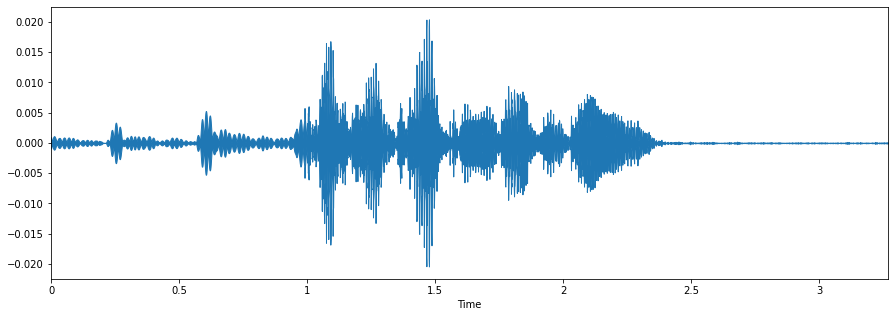

In [ ]:
% pylab inline
import os
import pandas as pd
import librosa

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  


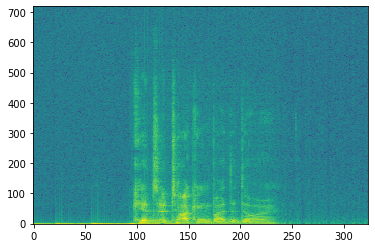

In [ ]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys

sr,x = scipy.io.wavfile.read('/content/drive/MyDrive/speech emotion recognition/Dataset/03-01-01-01-01-01-09.wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

## **Setting the labels & Data Preprocessing**

In [ ]:
feeling_list=[]
for item in mylist:
  
    if item[:1]=='a':
        feeling_list.append('male_angry')
    elif item[:1]=='f':
        feeling_list.append('male_fearful')
    elif item[:1]=='h':
        feeling_list.append('male_happy')
    elif item[:2]=='sa':
        feeling_list.append('male_sad')
        
    elif item[:2]>='10':
      if item[6:-16]=='03':
          feeling_list.append('female_happy')          
      elif item[6:-16]=='04':
          feeling_list.append('female_sad')
      elif item[6:-16]=='05':
          feeling_list.append('female_angry')
      elif item[6:-16]=='06':
          feeling_list.append('female_fearful')
    else:
      if item[6:-16]=='02' and int(item[18:-4])%2==0:
          feeling_list.append('female_calm')
      elif item[6:-16]=='02' and int(item[18:-4])%2==1:
          feeling_list.append('male_calm')
      elif item[6:-16]=='03' and int(item[18:-4])%2==0:
          feeling_list.append('female_happy')
      elif item[6:-16]=='03' and int(item[18:-4])%2==1:
          feeling_list.append('male_happy')
      elif item[6:-16]=='04' and int(item[18:-4])%2==0:
          feeling_list.append('female_sad')
      elif item[6:-16]=='04' and int(item[18:-4])%2==1:
          feeling_list.append('male_sad')
      elif item[6:-16]=='05' and int(item[18:-4])%2==0:
          feeling_list.append('female_angry')
      elif item[6:-16]=='05' and int(item[18:-4])%2==1:
          feeling_list.append('male_angry')
      elif item[6:-16]=='06' and int(item[18:-4])%2==0:
          feeling_list.append('female_fearful')
      elif item[6:-16]=='06' and int(item[18:-4])%2==1:
          feeling_list.append('male_fearful')

"""
dir_list = os.listdir("/content/drive/MyDrive/speech emotion recognition/TESS Toronto emotional speech set data")
for i in dir_list:
    fname = os.listdir("/content/drive/MyDrive/speech emotion recognition/TESS Toronto emotional speech set data/" + i)
    for f in fname:
        if i == 'OAF_angry' or i == 'YAF_angry':
            feeling_list.append('female_angry')
        elif i == 'OAF_Fear' or i == 'YAF_fear':
            feeling_list.append('female_fearful')
        elif i == 'OAF_happy' or i == 'YAF_happy':
            feeling_list.append('female_happy')        
        elif i == 'OAF_Sad' or i == 'YAF_sad':
            feeling_list.append('female_sad')
        #elif i == 'OAF_neutral' or i == 'YAF_neutral':
            #feeling_list.append('female_neutral')                                
        #elif i == 'OAF_Pleasant_surprise' or i == 'YAF_pleasant_surprised':
            #feeling_list.append('female_surprise')    
        #elif i == 'OAF_disgust' or i == 'YAF_disgust':
            #feeling_list.append('female_disgust')   
"""

'\ndir_list = os.listdir("/content/drive/MyDrive/speech emotion recognition/TESS Toronto emotional speech set data")\nfor i in dir_list:\n    fname = os.listdir("/content/drive/MyDrive/speech emotion recognition/TESS Toronto emotional speech set data/" + i)\n    for f in fname:\n        if i == \'OAF_angry\' or i == \'YAF_angry\':\n            feeling_list.append(\'female_angry\')\n        elif i == \'OAF_Fear\' or i == \'YAF_fear\':\n            feeling_list.append(\'female_fearful\')\n        elif i == \'OAF_happy\' or i == \'YAF_happy\':\n            feeling_list.append(\'female_happy\')        \n        elif i == \'OAF_Sad\' or i == \'YAF_sad\':\n            feeling_list.append(\'female_sad\')\n        #elif i == \'OAF_neutral\' or i == \'YAF_neutral\':\n            #feeling_list.append(\'female_neutral\')                                \n        #elif i == \'OAF_Pleasant_surprise\' or i == \'YAF_pleasant_surprised\':\n            #feeling_list.append(\'female_surprise\')    \n    

In [ ]:
labels = pd.DataFrame(feeling_list, columns={'labels'})
print(labels.labels.unique())

['female_fearful' 'female_angry' 'female_sad' 'female_happy' 'male_calm'
 'male_happy' 'male_sad' 'male_angry' 'male_fearful' 'female_calm']


**Getting the features of audio files using librosa**

In [ ]:
df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist):
    if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08' and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d':
        X, sample_rate = librosa.load('/content/drive/MyDrive/speech emotion recognition/Dataset/'+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                            sr=sample_rate, 
                                            n_mfcc=13),
                        axis=0)
        feature = mfccs
        df.loc[bookmark] = [feature]
        bookmark=bookmark+1    

In [ ]:
import keras.utils

In [ ]:
df[:5]

,feature
0,"[-20.730122, -19.28741, -18.097862, -19.381758..."
1,"[-6.3403225, -10.349282, -20.596178, -21.17180..."
2,"[-6.1908727, -10.767307, -25.903532, -26.30032..."
3,"[-11.453272, -15.099227, -23.107552, -21.03278..."
4,"[-15.549138, -17.520674, -22.816315, -24.77610..."


In [ ]:
df3 = pd.DataFrame(df['feature'].values.tolist())

In [ ]:
newdf = pd.concat([df3,labels], axis=1)
print(newdf.shape)

(2800, 217)


In [ ]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
rnewdf[:10]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,labels
1149,-64.069298,-61.583847,-60.199516,-61.399479,-63.011253,-64.362518,-64.340187,-62.380737,-57.205318,-56.506344,-55.407528,-55.028061,-54.182480,-51.286098,-51.690102,-53.531673,-53.901070,-54.445557,-53.575378,-53.459942,-56.252686,-55.815552,-53.803307,-52.188175,-53.216354,-55.699348,-54.951782,-51.747959,-51.520420,-52.376869,-57.084404,-59.751102,-57.500053,-57.675232,-58.041206,-59.633869,-58.211727,-52.115131,-50.796185,-54.729290,...,-43.149071,-45.489536,-43.857258,-43.488010,-44.975437,-45.981827,-49.045818,-50.778984,-49.663826,-50.738701,-52.584530,-54.514320,-53.282742,-52.640888,-51.464767,-51.073040,-52.584953,-53.922508,-54.797325,-55.149357,-58.647751,-61.262241,-58.751991,-58.789532,-61.626205,-60.958454,-55.016598,-53.179234,-53.906010,-57.565632,-61.704857,-61.492722,-60.767868,-58.912601,-60.554165,-57.685287,-55.272587,-57.469196,-61.436012,female_happy
1286,-13.886061,-18.039980,-33.130985,-32.123287,-31.344431,-30.635485,-30.362610,-29.676086,-30.685760,-30.442976,-30.615299,-30.902046,-31.289650,-31.307953,-31.896574,-33.504570,-32.568344,-31.539145,-32.906754,-33.353401,-34.408813,-36.974155,-37.611179,-34.071373,-32.877632,-33.402153,-34.260445,-31.966566,-31.273001,-31.757053,-31.633137,-31.296049,-32.356968,-30.001200,-29.682076,-28.979858,-27.833565,-28.079479,-28.725019,-28.949400,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,female_angry
2038,-56.020809,-55.617264,-55.249573,-55.412136,-54.860023,-53.800117,-51.929226,-50.367561,-49.699360,-50.277687,-51.158264,-50.850002,-49.855042,-49.316170,-49.700859,-50.777500,-51.606506,-52.183781,-51.975674,-49.710781,-49.679317,-51.553505,-52.027870,-51.725090,-52.540890,-53.536255,-50.220680,-50.143276,-51.313618,-50.321636,-48.807701,-48.676411,-50.236248,-51.497536,-51.531860,-53.156662,-56.383160,-57.317032,-56.626549,-54.335060,...,-43.072884,-44.110928,-44.793953,-45.468422,-44.627956,-43.983982,-43.216572,-43.000446,-41.975479,-40.317379,-41.400887,-42.173710,-41.558372,-41.656914,-43.288815,-44.508400,-46.345417,-47.368385,-48.889370,-47.669350,-48.590012,-48.883610,-48.934963,-49.411758,-48.698997,-47.546562,-47.727928,-49.429081,-52.206459,-52.207706,-50.861938,-49.661312,-49.058369,-47.725826,-47.595242,-48.072186,-48.019505,-48.827690,-50.340172,female_happy
1327,-21.424559,-23.308155,-30.438511,-32.379715,-31.563015,-30.839529,-31.074759,-31.555790,-31.354265,-30.858797,-31.530308,-31.083498,-30.440886,-31.205906,-31.176882,-31.180779,-31.400240,-31.633106,-32.565914,-32.720543,-32.710484,-32.074093,-33.560947,-33.845619,-33.216488,-32.318993,-32.133545,-32.538757,-34.368160,-32.624458,-31.366566,-31.226971,-31.143209,-31.857616,-31.067980,-29.209225,-25.931549,-26.382996,-25.297464,-28.868971,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,female_angry
1931,-48.578926,-46.895561,-47.236275,-48.486771,-48.078396,-47.657047,-48.304131,-48.670181,-49.700497,-51.626358,-51.896202,-51.691467,-51.743408,-51.513386,-50.034298,-48.711021,-49.949539,-49.609642,-47.529442,-45.680656,-45.640648,-46.261055,-45.858131,-45.401009,-45.319580,-47.873535,-48.661091,-50.770226,-51.272385,-51.586567,-51.691616,-50.557621,-50.463039,-49.890488,-48.814140,-49.510799,-51.704247,-50.400288,-48.784645,-48.909122,...,-21.244129,-23.694141,-25.458605,-24.867167,-25.192415,-27.131359,-26.345867,-24.604855,-24.711735,-25.697641,-24.747993,-22.905806,-23.459856,-24.023569,-22.888546,-22.553516,-25.044117,-23.883736,-25.543770,-25.949524,-26.493980,-26.941799,-27.700605,-2

In [ ]:
nulls = rnewdf.isnull().sum()
print(nulls)

0            0
1            0
2            0
3            0
4            0
          ... 
212       1648
213       1648
214       1649
215       1651
labels       0
Length: 217, dtype: int64


In [ ]:
rnewdf.dropna(subset = ["labels"], inplace=True)

In [ ]:
rnewdf=rnewdf.fillna(0)

In [ ]:
nulls = rnewdf.isnull().sum()
print(nulls)

0         0
1         0
2         0
3         0
4         0
         ..
212       0
213       0
214       0
215       0
labels    0
Length: 217, dtype: int64


## **Dividing the data into test and train**

In [ ]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [ ]:
!pip install np_utils

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(rnewdf.iloc[:, :-1], rnewdf.iloc[:, -1:], test_size=0.2, shuffle=True, random_state=42)

#X_train = np.array(trainfeatures)
#y_train = np.array(trainlabel)
#X_test = np.array(testfeatures)
#y_test = np.array(testlabel)
#y_test_cm = np.array(testlabel)

lb = LabelEncoder()

y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
y_train.shape

(2240, 10)

In [ ]:
y_test.shape

(560, 10)

In [ ]:
x_train.shape

(2240, 216)

In [ ]:
y_test.shape

(560, 10)

## **Changing dimension for CNN model**

In [ ]:
x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)

In [ ]:
import tensorflow.keras
from tensorflow.keras import optimizers
from keras import optimizers

model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
opt = tensorflow.keras.optimizers.RMSprop(learning_rate=0.00005, decay=1e-6)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 216, 256)          1536      
                                                                 
 activation_5 (Activation)   (None, 216, 256)          0         
                                                                 
 conv1d_5 (Conv1D)           (None, 216, 128)          163968    
                                                                 
 activation_6 (Activation)   (None, 216, 128)          0         
                                                                 
 dropout_1 (Dropout)         (None, 216, 128)          0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 27, 128)          0         
 1D)                                                             
                                                      

In [ ]:
!pip install tensorflow_addons

In [ ]:
import tensorflow_addons
from tensorflow_addons.metrics import FBetaScore, F1Score

In [ ]:
from tensorflow.keras.metrics import Precision, Recall

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy',
                        Precision(name='precision'),
                        Recall(name='recall'),
                        F1Score(num_classes=10, name='F1Score')])

### **Removed the whole training part for avoiding unnecessary long epochs list**

In [ ]:
cnnhistory = model.fit(x_traincnn, y_train, batch_size=64, epochs=150, validation_split=0.2)

Epoch 1/150
28/28 [==============================] - 12s 383ms/step - loss: 1.9642 - accuracy: 0.3013 - precision: 0.6727 - recall: 0.0206 - F1Score: 0.1731 - val_loss: 1.7860 - val_accuracy: 0.3594 - val_precision: 0.8333 - val_recall: 0.0223 - val_F1Score: 0.2342
Epoch 2/150
28/28 [==============================] - 10s 365ms/step - loss: 1.5744 - accuracy: 0.4118 - precision: 0.7200 - recall: 0.1607 - F1Score: 0.2633 - val_loss: 1.5840 - val_accuracy: 0.3996 - val_precision: 0.7029 - val_recall: 0.2165 - val_F1Score: 0.2170
Epoch 3/150
28/28 [==============================] - 10s 363ms/step - loss: 1.4673 - accuracy: 0.4425 - precision: 0.7341 - recall: 0.2835 - F1Score: 0.2906 - val_loss: 1.5603 - val_accuracy: 0.4464 - val_precision: 0.7308 - val_recall: 0.2545 - val_F1Score: 0.2902
Epoch 4/150
28/28 [==============================] - 10s 363ms/step - loss: 1.4231 - accuracy: 0.4464 - precision: 0.7251 - recall: 0.3209 - F1Score: 0.3093 - val_loss: 1.4852 - val_accuracy: 0.4576 - v

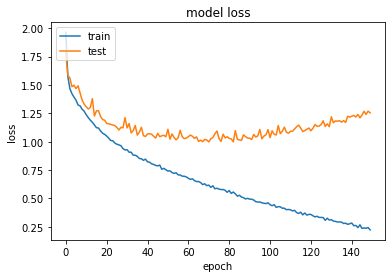

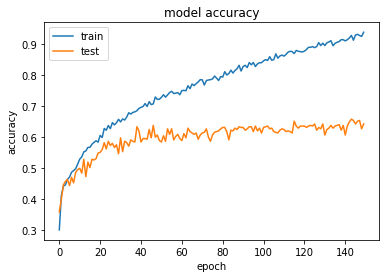

In [ ]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])  
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## **Saving the model**

In [ ]:
import os
model_name = 'model corrected.h5'
save_dir = '/content/drive/MyDrive/speech emotion recognition/saved_models/'
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
    
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/drive/MyDrive/speech emotion recognition/saved_models/model corrected.h5 


In [ ]:
import json
model_json = model.to_json()
with open(save_dir + "model corrected.json", "w") as json_file:
    json_file.write(model_json)

## **Loading the model**

In [ ]:
# loading json and creating model
from keras.models import model_from_json
save_dir = '/content/drive/MyDrive/speech emotion recognition/saved_models/'
json_file = open(save_dir + 'model corrected.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(save_dir + 'model corrected.h5')
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy',
                    optimizer=opt,
                    metrics=['accuracy',
                              Precision(name='precision'),
                              Recall(name='recall'),
                              F1Score(num_classes=10, name='F1Score')])

score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))
print("%s: %.2f%%" % (loaded_model.metrics_names[2], score[2]*100))
print("%s: %.2f%%" % (loaded_model.metrics_names[3], score[3]*100)) 

Loaded model from disk
accuracy: 66.96%
precision: 70.70%
recall: 64.64%


In [ ]:
score[4]*100

array([73.77049 , 64.864876, 66.666664, 76.68394 , 85.333336, 46.80851 ,
       45.454548, 14.634146, 31.25    , 32.65306 ], dtype=float32)

In [ ]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=2)                      

18/18 - 1s - 758ms/epoch - 42ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(x_testcnn, batch_size=32, verbose=0)

y_pred_bool = np.argmax(y_pred, axis=1)
y_test_bool = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_bool, y_pred_bool)
print(cm)

[[90  0 12  7  7  2  0  1  2  2]
 [ 1 12  3  3  1  0  1  0  0  0]
 [18  0 66 12  3  0  0  0  1  1]
 [ 4  0  7 74  1  1  0  0  0  0]
 [ 5  3  2  7 96  0  0  0  1  1]
 [ 1  0  1  1  1 11  0  1  5  2]
 [ 0  0  0  0  0  0  5  2  1  7]
 [ 0  1  2  1  0  2  0  3 12  4]
 [ 2  0  3  1  1  6  0  3 10  3]
 [ 0  0  1  0  0  2  1  6  3  8]]


In [ ]:
cr = classification_report(y_test_bool, y_pred_bool)
print(cr)

              precision    recall  f1-score   support

           0       0.74      0.73      0.74       123
           1       0.75      0.57      0.65        21
           2       0.68      0.65      0.67       101
           3       0.70      0.85      0.77        87
           4       0.87      0.83      0.85       115
           5       0.46      0.48      0.47        23
           6       0.71      0.33      0.45        15
           7       0.19      0.12      0.15        25
           8       0.29      0.34      0.31        29
           9       0.29      0.38      0.33        21

    accuracy                           0.67       560
   macro avg       0.57      0.53      0.54       560
weighted avg       0.67      0.67      0.67       560



In [ ]:
preds

array([[3.0613161e-04, 5.6355136e-29, 3.5059824e-15, ..., 8.4189407e-05,
        1.2213197e-04, 9.7127622e-07],
       [2.1391572e-02, 1.3563569e-19, 9.7841120e-01, ..., 7.0498453e-07,
        2.1089516e-05, 4.4743385e-07],
       [1.1649391e-02, 1.5205955e-15, 9.4136981e-13, ..., 1.2104510e-03,
        5.6967645e-05, 1.4045845e-02],
       ...,
       [7.6320715e-04, 1.5292284e-06, 6.1237872e-01, ..., 7.1761094e-02,
        2.9317763e-02, 1.1698218e-03],
       [9.9462408e-01, 1.9916168e-20, 6.4291007e-06, ..., 1.8790805e-06,
        2.2428739e-04, 6.2695869e-07],
       [1.9721063e-03, 7.7213514e-01, 7.8183867e-02, ..., 5.3488108e-04,
        9.3002309e-04, 1.8302871e-02]], dtype=float32)

In [ ]:
preds1=preds.argmax(axis=1)

In [ ]:
abc = preds1.astype(int).flatten()

In [ ]:
predictions = (lb.inverse_transform((abc)))

In [ ]:
preddf = pd.DataFrame({'predictedvalues': predictions})

In [ ]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))
actualdf = pd.DataFrame({'actualvalues': actualvalues})

finaldf = actualdf.join(preddf)

In [ ]:
finaldf[:10]

,actualvalues,predictedvalues
0,female_sad,female_sad
1,female_fearful,female_fearful
2,female_sad,female_sad
3,female_angry,female_angry
4,female_angry,female_angry
5,female_fearful,female_fearful
6,female_angry,female_angry
7,male_fearful,male_happy
8,female_happy,female_happy
9,female_sad,female_sad


In [ ]:
finaldf.to_csv(save_dir + '/Predictions.csv', index=False)

## **Live Demo**

In [ ]:
data, sampling_rate = librosa.load('/content/drive/MyDrive/speech emotion recognition/Recorded Audios/recording2.wav')

Populating the interactive namespace from numpy and matplotlib


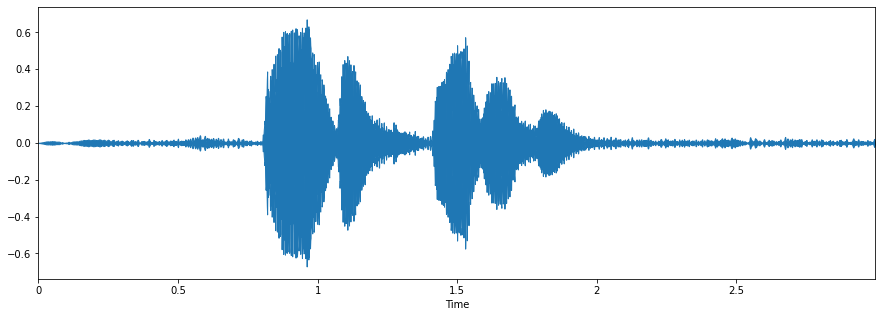

In [ ]:
% pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [ ]:
#livedf= pd.DataFrame(columns=['feature'])
X, sample_rate = librosa.load('/content/drive/MyDrive/speech emotion recognition/Recorded Audios/recording3.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive

In [ ]:
livedf2= pd.DataFrame(data=livedf2)

In [ ]:
livedf2 = livedf2.stack().to_frame().T

In [ ]:
livedf2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215
,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,-10.342405,-10.542077,-10.734669,-12.152303,-13.230002,-11.721354,-11.747549,-13.200709,-14.057817,-14.253041,-15.791761,-13.59576,-11.231223,-10.880141,-12.282669,-12.449717,-13.818599,-12.72374,-12.459982,-15.753559,-14.120353,-11.255375,-8.229468,-6.195348,-4.595813,-3.865882,-2.672335,-2.957268,-1.755361,0.025723,0.018167,-1.065914,-2.310527,-2.090195,-1.60061,-3.048487,-3.032268,-0.772506,1.227756,0.11811,...,-15.545538,-12.569155,-11.027986,-10.766314,-12.592283,-10.760469,-9.670299,-11.216867,-14.173705,-14.83776,-13.129539,-12.726516,-14.963156,-15.749327,-14.831348,-12.774656,-13.260909,-12.432667,-11.454666,-12.344967,-10.673674,-10.477635,-11.025687,-9.244098,-8.815282,-9.102205,-8.764978,-12.303046,-12.622817,-11.11996,-10.721788,-10.77481,-11.100413,-12.20898,-12.939902,-13.457017,-12.276854,-9.945031,-10.326087,-14.757708


In [ ]:
twodim= np.expand_dims(livedf2, axis=2)

In [ ]:
livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)

1/1 [==============================] - 0s 22ms/step


In [ ]:
classes = np.array([0,1,2,3,4,5,6,7,8,9])
classes = (lb.inverse_transform(classes))
classes = pd.DataFrame({'Class Label': classes})
preddd = pd.DataFrame({'Predictions': livepreds[0]*100})
results = classes.join(preddd)
results

,Class Label,Predictions
0,female_angry,1.586039e-03
1,female_calm,6.666724e-10
2,female_fearful,1.833576e-03
3,female_happy,2.144663e-07
4,female_sad,3.374426e-02
5,male_angry,8.689408e-01
6,male_calm,3.832384e-05
7,male_fearful,7.423251e+01
8,male_happy,1.947514e+01
9,male_sad,5.386210e+00


In [ ]:
livepreds1=livepreds.argmax(axis=1)
liveabc = livepreds1.astype(int).flatten()
livepredictions = (lb.inverse_transform((liveabc)))
livepredictions[0]

'male_fearful'